# ML Project: Data analysis

### Authors: Federico Minutoli & Gianvito Losapio

In [1]:
%pylab inline

import pandas as pd

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
CSV_DIR = "./shared_data"

## Tables analysis

### Forecasted temperature
This dataset contains the:
* ```forecast_date```: When the forecast is available
* ```value_date```: Date for which the forecast is made. There could be more forecasts (several releases) for the same date
* ```temperature_energy_adjusted```: The forecasted average temperature (C) of the north Italy adjusted on the expected energy consumption of the region

**N.B.:** Data is available only after it is forecasted.

In [5]:
forecast_temp_df = pd.read_csv(CSV_DIR + "/weather/forecast/temperature.csv",sep=';')

In [6]:
forecast_temp_df.tail()

,forecast_date,value_date,temperature_energy_adjusted
227119,07.03.2019 18:00:00,11.03.2019 08:00:00,9.104411
227120,07.03.2019 18:00:00,11.03.2019 09:00:00,10.398238
227121,07.03.2019 18:00:00,11.03.2019 10:00:00,10.739623
227122,07.03.2019 18:00:00,11.03.2019 11:00:00,10.960937
227123,07.03.2019 18:00:00,11.03.2019 12:00:00,10.921744


In [7]:
# The emission day of the forecast is not as important as the actual
# forecasted date thus we drop it. Indeed, we just want to correlate
# the forecasted date with the temperature adjusted on the expected
# energy consumption in the northern region of Italy, which may
# be relevant for our case study.
forecast_temp_df = forecast_temp_df.drop(columns='forecast_date')

# There are several forecasts over time for the same day, thus we consider
# only the most recent forecasts as they are the most reliable.
# (They are the last in the table)
forecast_temp_df = forecast_temp_df.drop_duplicates(['value_date'], keep='last')


# 1. Create date objects for each value_date,
#    since time information isn't of any use
forecast_temp_date = pd.to_datetime(forecast_temp_df['value_date'],
                          format='%d.%m.%Y %H:%M:%S').dt.date

# 2. Assign object attributes.

# # Note that the columns month, year, date are useful later on in order
# # to join tables together and form a single date column

# forecast_temps_df['month'] = forecast_temp_date.month
# forecast_temps_df['year']  = forecast_temp_date.year
# forecast_temps_df['day']   = forecast_temp_date.day

# --> NB: Changed to keep a single column only!
forecast_temp_df['date'] = forecast_temp_date

# Normalize data to 28/02/2019
last_available_date = pd.datetime(year=2019, month=3, day=1).date()
# Logical matrix where condition is True
norm_condition = forecast_temp_df.date < last_available_date

# Filter forecast_temps_df
forecast_temp_df = forecast_temp_df.loc[norm_condition]

# Drop useless columns
forecast_temp_df = forecast_temp_df.drop(columns='value_date')

# Obtain daily forecasts 
daily_temp_df = forecast_temp_df.groupby(['date']) \
                        .agg(temp_adjusted_mean=('temperature_energy_adjusted', 'mean')).reset_index()
                    
del forecast_temp_df

In [8]:
daily_temp_df.head()

,date,temp_adjusted_mean
0,2018-01-01,6.705066
1,2018-01-02,7.323310
2,2018-01-03,5.457443
3,2018-01-04,6.347944
4,2018-01-05,7.350037


### Renewable energy
This dataset contains the amount of produced renewable energy. The columns are:
* ```Date```: Reference date
* ```Hydro```: Amount of hydroelectric energy (GWh)
* ```Photovoltaic```: Amount of photovoltaic energy (GWh)
* ```Wind```: Amount of wind energy (GWh)


**N.B.:** Data is available only two hours later the reference date.

In [9]:
renewable_nrg_df = pd.read_csv(CSV_DIR + '/renewable_energy/renewable_energy.csv',sep=';')

In [10]:
renewable_nrg_df.tail()

,Date,Hydro,Photovoltaic,Wind
10339,2019-03-07 19:00:00,5.338576,0.000000,4.245287
10340,2019-03-07 20:00:00,3.782988,0.006180,4.245827
10341,2019-03-07 21:00:00,3.236407,0.000000,4.187169
10342,2019-03-07 22:00:00,2.336690,0.000000,4.200989
10343,2019-03-07 23:00:00,2.114114,0.014856,4.246700


In [11]:
# Sum the hourly produced renewable energy in HPW
renewable_nrg_df['HPW'] = (renewable_nrg_df['Hydro'] + renewable_nrg_df['Photovoltaic'] \
                               + renewable_nrg_df['Wind'])

# Drop the original columns and keep only the sum,
# since as we said in `Useful knowledge` only
# hydroelectric energy is relevant for this case study
renewable_nrg_df = renewable_nrg_df.drop(columns=['Photovoltaic', 'Wind'])

# Same processing as before

renewable_nrg_date = pd.to_datetime(renewable_nrg_df['Date'],
                        format='%Y-%m-%d %H:%M:%S').dt.date

renewable_nrg_df['date'] = renewable_nrg_date

# Normalize data to 28/02/2019
last_available_date = pd.datetime(year=2019, month=3, day=1).date()
norm_condition = renewable_nrg_df.date < last_available_date

renewable_nrg_df = renewable_nrg_df.drop(columns='Date')
renewable_nrg_df = renewable_nrg_df[norm_condition]

daily_renewable_nrg_df = renewable_nrg_df.groupby(['date']) \
                                .agg(renewable_nrg_tot=('HPW', 'sum'),
                                        hydro_tot=('Hydro', 'sum')).reset_index()

del renewable_nrg_df

In [12]:
daily_renewable_nrg_df.tail()

,date,renewable_nrg_tot,hydro_tot
419,2019-02-24,248.438848,65.304957
420,2019-02-25,249.662670,84.554349
421,2019-02-26,245.767538,96.128528
422,2019-02-27,252.040928,81.976307
423,2019-02-28,201.581870,85.633488


### Energy production costs
This dataset contains the energy production costs only for thermal plants (a.k.a. **CCGT**). Rows are:
* ```date```: The reference date
* ```hour```: The reference hour
* ```energy_cost_thermal_plant_euro_MWh```: The energy cost (€/MWh) for a closed-cycle thermal plant

***N.B.:*** Data are available the same day of the energy delivery.

In [13]:
energy_prod_costs_df = pd.read_csv(CSV_DIR + '/production_cost/production_cost.csv',sep=';')

In [14]:
energy_prod_costs_df.tail()

,date,hour,energy_cost_thermal_plant_euro_MWh
10339,2019-03-07,20,51.4
10340,2019-03-07,21,51.4
10341,2019-03-07,22,51.4
10342,2019-03-07,23,51.4
10343,2019-03-07,24,51.4


In [15]:
# Same processing as before

energy_prod_costs_date = pd.to_datetime(energy_prod_costs_df['date'],
                              format='%Y-%m-%d').dt.date

energy_prod_costs_df['date'] = energy_prod_costs_date

# Normalize data to 28/02/2019
last_available_date = pd.datetime(year=2019, month=3, day=1).date()
norm_condition = energy_prod_costs_df.date < last_available_date

energy_prod_costs_df = energy_prod_costs_df[norm_condition]

daily_energy_prod_costs_df = energy_prod_costs_df.groupby(['date']) \
                                    .agg(ccgt_prod_cost_mean=('energy_cost_thermal_plant_euro_MWh', 'mean')).reset_index()

del energy_prod_costs_df

In [16]:
daily_energy_prod_costs_df.tail()

,date,ccgt_prod_cost_mean
419,2019-02-24,52.1
420,2019-02-25,52.0
421,2019-02-26,51.5
422,2019-02-27,51.3
423,2019-02-28,52.2


### Accepted amount of Energy
Each row of this dataset describes the amount of energy (MWh) accepted in MGP or MSD market.
* ```class```: Could be ```bid``` for a demand bid or ```offer``` for  a supply offer
* ```market```: ```MGP``` or ```MSD```
* ```date```: Reference date
* ```hour```: Reference hour
* ```energy_amount```: Rhe accepted amount of energy

**N.B.** Data are available at the closure of the market (i.e. the 12:55 of the day before the day of delivery for **MGP** and 18:15 of the day of delivery for **MSD**).

In [17]:
acc_energy_df = pd.read_csv(CSV_DIR + '/volume/volume.csv',sep=';')

In [18]:
acc_energy_df.tail()

,class,market,date,hour,energy_amount
41323,offer,MGP,20190307,20,18162.901
41324,offer,MGP,20190307,21,17226.354
41325,offer,MGP,20190307,22,15281.039
41326,offer,MGP,20190307,23,12653.797
41327,offer,MGP,20190307,24,10768.299


In [19]:
# Consider only offer (not bid)
acc_energy_df = acc_energy_df.loc[acc_energy_df['class'] == 'offer']
acc_energy_df = acc_energy_df.drop(columns='class')

acc_energy_date = pd.to_datetime(acc_energy_df['date'],
                        format='%Y%m%d').dt.date

acc_energy_df['date'] = acc_energy_date

# Normalize data to 28/02/2019
last_available_date = pd.datetime(year=2019, month=3, day=1).date()
norm_condition = acc_energy_df.date < last_available_date

acc_energy_df = acc_energy_df[norm_condition]
acc_energy_df = acc_energy_df.drop(columns='hour')

# Split MGP and MSD

acc_energy_mgp_df = acc_energy_df.loc[acc_energy_df['market'] == 'MGP']
acc_energy_msd_df = acc_energy_df.loc[acc_energy_df['market'] == 'MSD']

del acc_energy_df

acc_energy_mgp_df = acc_energy_mgp_df.drop(columns='market')
acc_energy_msd_df = acc_energy_msd_df.drop(columns='market')

daily_acc_energy_mgp_df = acc_energy_mgp_df.groupby(['date']) \
                                .agg(accepted_mgp_nrg_tot=('energy_amount', 'sum')).reset_index()

daily_acc_energy_msd_df = acc_energy_mgp_df.groupby(['date']) \
                                .agg(accepted_msd_nrg_tot=('energy_amount', 'sum')).reset_index()

del acc_energy_mgp_df
del acc_energy_msd_df

# Convert to GWh
daily_acc_energy_mgp_df['accepted_mgp_nrg_tot'] /= 1000
daily_acc_energy_msd_df['accepted_msd_nrg_tot'] /= 1000

daily_acc_energy_mgp_df['accepted_nrg_tot'] = daily_acc_energy_mgp_df['accepted_mgp_nrg_tot'] \
                        + daily_acc_energy_msd_df['accepted_msd_nrg_tot']

daily_acc_energy_df = daily_acc_energy_mgp_df

del daily_acc_energy_mgp_df
del daily_acc_energy_msd_df

# Assume 10% of the total energy produced every day
# isn't sold and thus, not accepted by anyone.
daily_acc_energy_df['thermal_nrg_tot'] = daily_acc_energy_df['accepted_nrg_tot'] * (10/9) \
                        - daily_renewable_nrg_df['renewable_nrg_tot']

daily_acc_energy_df.drop(columns='accepted_nrg_tot', inplace=True)

In [20]:
daily_acc_energy_df.tail()

,date,accepted_mgp_nrg_tot,thermal_nrg_tot
419,2019-02-24,219.861865,240.143074
420,2019-02-25,357.588975,544.979497
421,2019-02-26,368.665675,573.489517
422,2019-02-27,346.938727,518.934021
423,2019-02-28,388.007038,660.655993


### Accepted prices

Each row of this dataset describes the prices accepted in **MGP** or **MSD** market.
* ```class```: Could be ```bid``` for a demand bid or ```offer``` for  a supply offer
* ```market```: ```MGP``` or ```MSD```
* ```date```: Reference date
* ```hour```: Reference hour
* ```price```: The accepted price

**N.B.** Data are available at the closure of the market (i.e. the 12:55 of the day before the day of delivery for **MGP** and 18:15 of the day of delivery for **MSD**).

In [21]:
acc_price_df = pd.read_csv(CSV_DIR + '/price/price.csv',sep=';')

In [22]:
acc_price_df.tail()

,class,market,date,hour,price
41323,offer,MSD,20190306,20,77.382122
41324,offer,MSD,20190306,21,76.805770
41325,offer,MSD,20190306,22,77.130419
41326,offer,MSD,20190306,23,78.367224
41327,offer,MSD,20190306,24,75.952538


In [23]:
# Consider only offer (not bid)
acc_price_df = acc_price_df.loc[acc_price_df['class'] == 'offer']
acc_price_df = acc_price_df.drop(columns='class')

# Avoid empty prices
acc_price_df = acc_price_df.loc[acc_price_df['price'] != 0.000000]

acc_price_date = pd.to_datetime(acc_price_df['date'],
                        format='%Y%m%d').dt.date

acc_price_df['date'] = acc_price_date

# Normalize data to 28/02/2019
last_available_date = pd.datetime(year=2019, month=3, day=1).date()
norm_condition = acc_price_df.date < last_available_date

acc_price_df = acc_price_df[norm_condition]
acc_price_df = acc_price_df.drop(columns='hour')

# Split MGP and MSD

acc_price_mgp_df = acc_price_df.loc[acc_price_df['market'] == 'MGP']
acc_price_mgp_df = acc_price_mgp_df.drop(columns='market')

daily_acc_price_mgp_df = acc_price_mgp_df.groupby(['date']) \
                                .agg(accepted_price_mgp_mean=('price', 'mean')).reset_index()

del acc_price_df
del acc_price_mgp_df

In [24]:
daily_acc_price_mgp_df.tail()

,date,accepted_price_mgp_mean
419,2019-02-24,46.916292
420,2019-02-25,57.196063
421,2019-02-26,57.323333
422,2019-02-27,55.170382
423,2019-02-28,58.167026


### Target: Number of Plants

In [25]:
train_df = pd.read_pickle(CSV_DIR + '/target/target_number_of_plants.pkl')

In [26]:
train_df = pd.read_pickle(CSV_DIR + '/target/target_number_of_plants.pkl')

test_target_df = train_df.tail(7)
train_df.drop(test_target_df.index, inplace=True)

# The target DF has 2 indexes, participant and technology,
# thus we use unstack() to remove them.
train_df = train_df.unstack().reset_index() \
                .drop(columns='level_0')

# Rename the column created as 0
train_df = train_df.rename(columns={0: 'n_acc_offers'})

# Do the same things for test_df
test_target_df = test_target_df.unstack().reset_index() \
                .drop(columns='level_0')

test_target_df = test_target_df.rename(columns={0: 'n_acc_offers'})

# Adjust date column
train_date = pd.to_datetime(train_df['date'],
                    format='%Y%m%d').dt.date

test_target_date = pd.to_datetime(test_target_df['date'],
                    format='%Y%m%d').dt.date

train_df['date'] = train_date
test_target_df['date']  = test_target_date

In [27]:
# Merge all the DFs together
train_df = train_df.merge(daily_temp_df, on=['date']) \
                        .merge(daily_renewable_nrg_df, on=['date']) \
                        .merge(daily_energy_prod_costs_df, on=['date']) \
                        .merge(daily_acc_energy_df, on=['date']) \
                        .merge(daily_acc_price_mgp_df, on=['date'])

In [28]:
train_df.index = pd.DatetimeIndex(data=train_df.date)
test_target_df.index = pd.DatetimeIndex(data=test_target_df.date)

In [29]:
train_df.tail()

,participant,technology,date,n_acc_offers,temp_adjusted_mean,renewable_nrg_tot,hydro_tot,ccgt_prod_cost_mean,accepted_mgp_nrg_tot,thermal_nrg_tot,accepted_price_mgp_mean
date,,,,,,,,,,,
2019-02-21,participant_96,ccgt400,2019-02-21,3,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.2075
2019-02-21,participant_96,ccgt800,2019-02-21,0,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.2075
2019-02-21,participant_96,coal,2019-02-21,3,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.2075
2019-02-21,participant_96,pump,2019-02-21,0,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.2075
2019-02-21,participant_96,reservoir,2019-02-21,2,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.2075


In [30]:
test_target_df.tail()

,participant,technology,date,n_acc_offers
date,,,,
2019-02-24,participant_96,reservoir,2019-02-24,1
2019-02-25,participant_96,reservoir,2019-02-25,2
2019-02-26,participant_96,reservoir,2019-02-26,2
2019-02-27,participant_96,reservoir,2019-02-27,3
2019-02-28,participant_96,reservoir,2019-02-28,3


## Time-series analysis

Main Reference:

Viktoriya Bodnar, Predictive Maintenance using Time Series Analysis and Machine Learning, Master Thesis, DIBRIS, Università di Genova, a.y. 2019/2020, supervisor prof. Alessandro Verri

We have:

6 unique *Technologies*:
- ccgt
- ccgt400
- ccgt800
- coal
- pump
- reservoir

11 unique *Participants*:
- participant_21
- participant_60
- participant_75
- participant_87
- participant_89
- participant_96
- participant_120
- participant_146
- participant_158
- participant_176

This resolves in 28 unique pairs.

In [31]:
# print(len(pd.unique(train_df.technology)))

In [32]:
import matplotlib.pyplot as plt

# Helper function to plot DFs
def plot_DF(X, Y, title="", xlabel='Date', ylabel='Number of Accepted offers', dpi=100):
    plt.figure(figsize=(16,3), dpi=dpi)
    plt.plot(X, Y, color='tab:blue')
    
    plt.title(title, fontsize=12)
    
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    
    plt.show() 

In [33]:
# Obtain all the (participant-technology) pairs
unique_pairs = train_df.groupby(['participant','technology']) \
    .size().reset_index().drop(columns={0}).values

# # Randomly select 5 time-series to analyze
# rnd_selected = []

# for i in np.random.permutation(len(unique_pairs))[:5]:
#     rnd_selected.append(unique_pairs[i])
    
# print(rnd_selected)

In [34]:
# Time-series about to be analyzed
time_series = []

for pair in unique_pairs:
    # Extract corrisponding time-series
    ts = train_df[np.logical_and(train_df.participant == pair[0],
                        train_df.technology == pair[1])] \
                .reset_index(drop=True)
    
    # Set the date column as a DatetimeIndex, which
    # is useful for plots and later processing.
    ts.index = pd.DatetimeIndex(data=ts.date)    
    time_series.append(ts)

### Variables plots

Randomly select a single time-series to analyze

In [35]:
ts_id = np.random.randint(0, len(time_series), size=1)[0]

ts = time_series[ts_id]
ts.head()

,participant,technology,date,n_acc_offers,temp_adjusted_mean,renewable_nrg_tot,hydro_tot,ccgt_prod_cost_mean,accepted_mgp_nrg_tot,thermal_nrg_tot,accepted_price_mgp_mean
date,,,,,,,,,,,
2018-01-01,participant_116,ccgt400,2018-01-01,2,6.705066,193.621283,58.437416,49.3,215.816814,285.971637,45.337500
2018-01-02,participant_116,ccgt400,2018-01-02,2,7.323310,227.393858,82.925698,49.2,270.208227,373.068869,39.955061
2018-01-03,participant_116,ccgt400,2018-01-03,2,5.457443,226.303612,88.067452,48.2,278.715408,393.063962,52.245000
2018-01-04,participant_116,ccgt400,2018-01-04,2,6.347944,205.518491,80.093910,47.5,268.675256,391.537633,42.843750
2018-01-05,participant_116,ccgt400,2018-01-05,2,7.350037,192.497161,89.390917,47.2,285.251325,441.394672,51.375833


C:\Users\gvlos\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


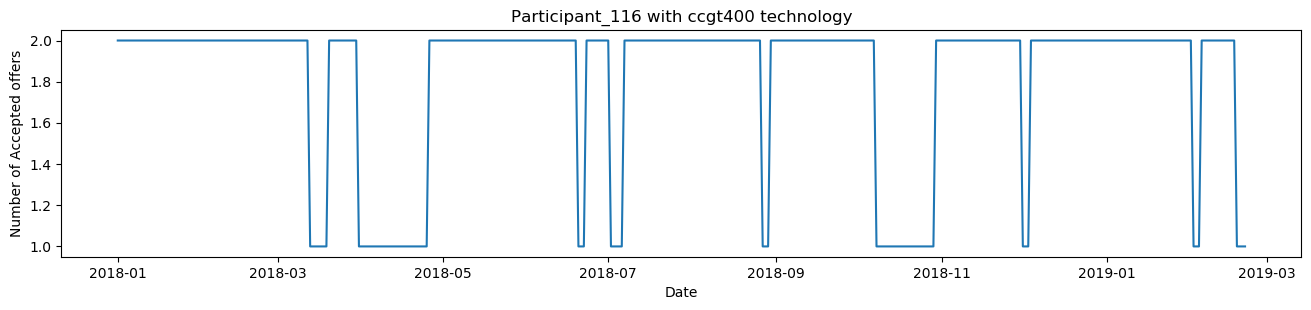

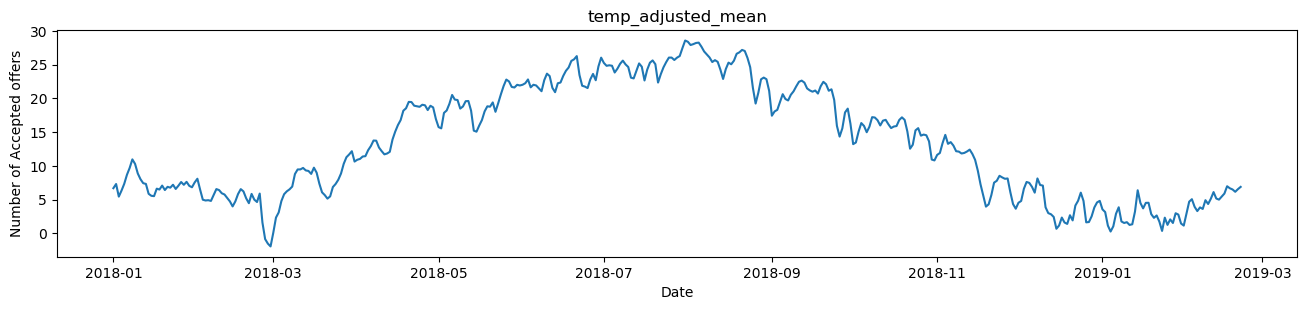

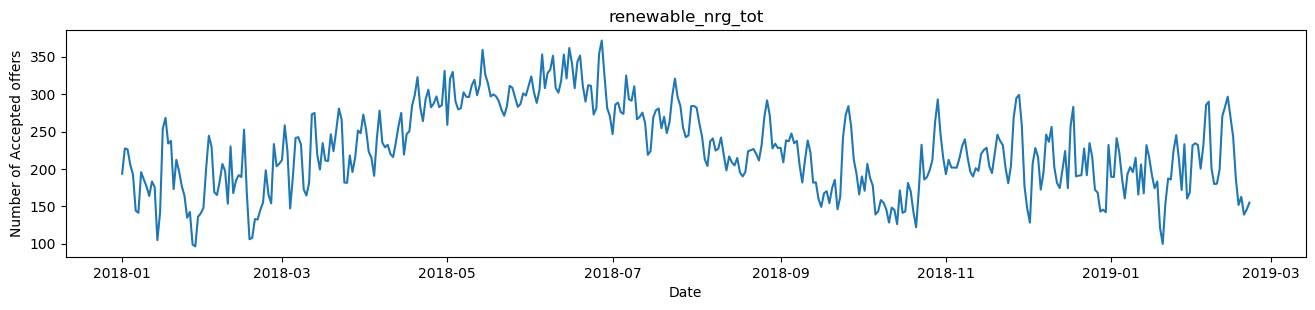

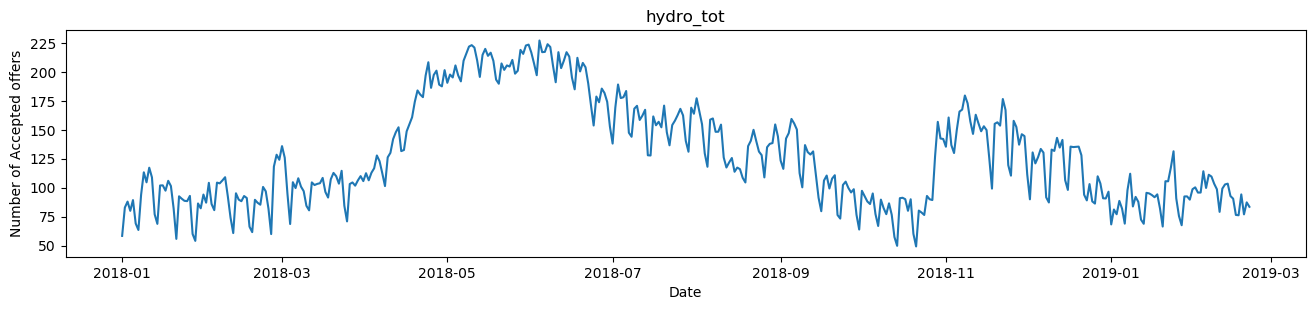

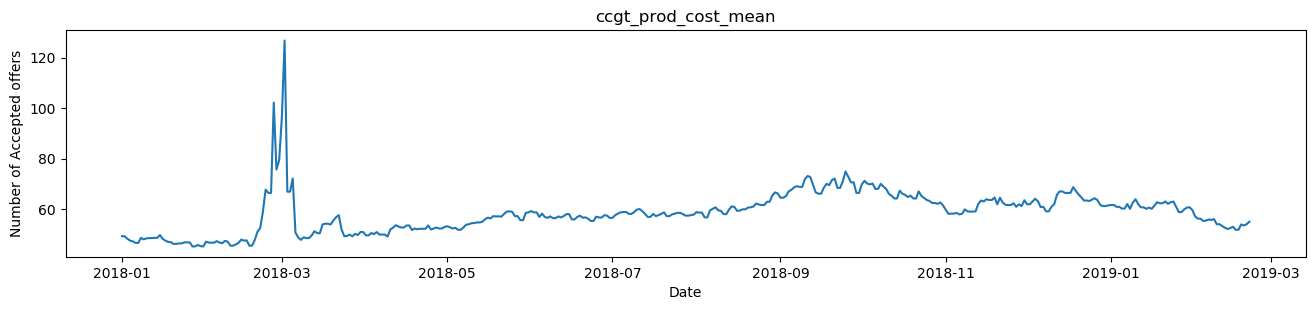

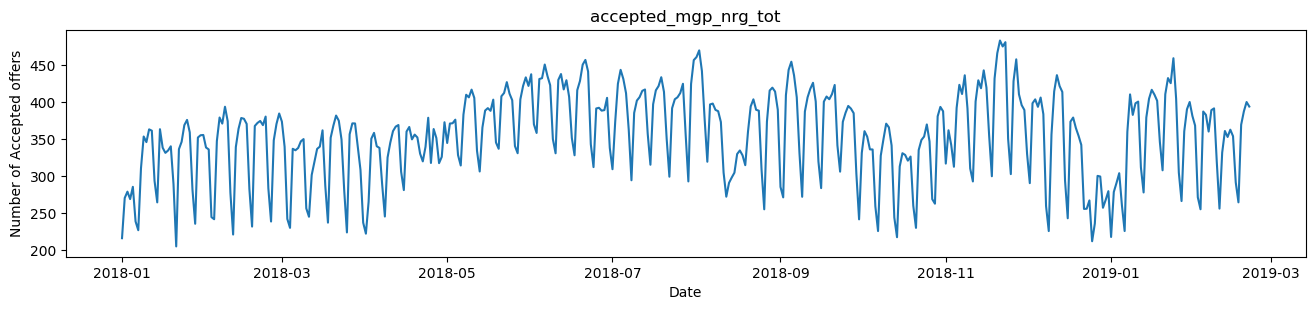

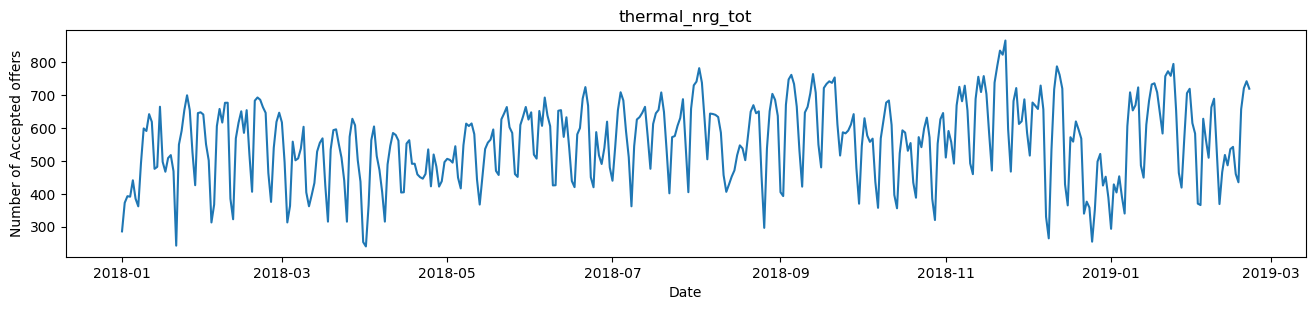

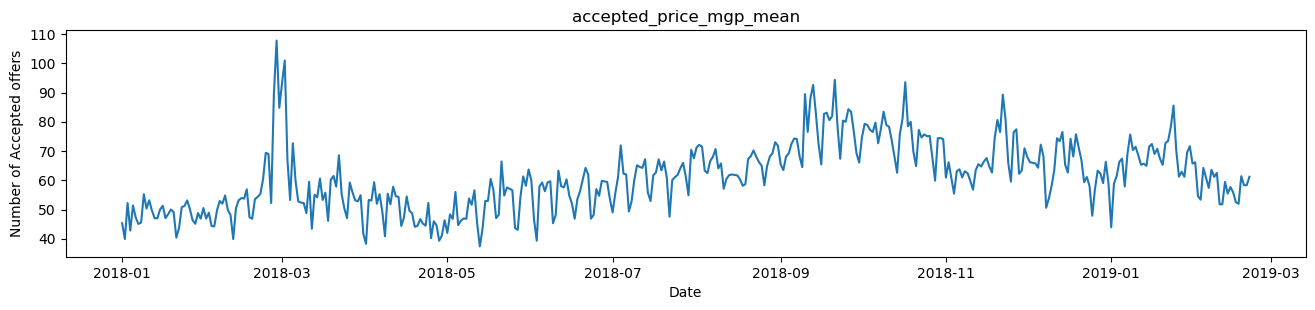

In [36]:
# Plot the target variable of the selected time-series
plot_DF(X=ts.index, Y=ts.n_acc_offers, title='%s with %s technology' \
                % (unique_pairs[ts_id][0].capitalize(), unique_pairs[ts_id][1]))

# Plot the remaining variables of the time-series
for col in ts.columns[4:]:
    plot_DF(X=ts.index, Y=ts[col], title='%s' % col) 

### Monthly box plots

Prepare data for monthly analysis

In [39]:
ts.head()

,participant,technology,date,n_acc_offers,temp_adjusted_mean,renewable_nrg_tot,hydro_tot,ccgt_prod_cost_mean,accepted_mgp_nrg_tot,thermal_nrg_tot,accepted_price_mgp_mean,day,month
date,,,,,,,,,,,,,
2018-01-01,participant_116,ccgt400,2018-01-01,2,6.705066,193.621283,58.437416,49.3,215.816814,285.971637,45.337500,1,1
2018-01-02,participant_116,ccgt400,2018-01-02,2,7.323310,227.393858,82.925698,49.2,270.208227,373.068869,39.955061,2,1
2018-01-03,participant_116,ccgt400,2018-01-03,2,5.457443,226.303612,88.067452,48.2,278.715408,393.063962,52.245000,3,1
2018-01-04,participant_116,ccgt400,2018-01-04,2,6.347944,205.518491,80.093910,47.5,268.675256,391.537633,42.843750,4,1
2018-01-05,participant_116,ccgt400,2018-01-05,2,7.350037,192.497161,89.390917,47.2,285.251325,441.394672,51.375833,5,1


In [40]:
# Add month and day columns
ts['day']   = [d.day for d in ts.date]
ts['month'] = [d.month for d in ts.date]

# Prepare plot's colors
np.random.seed(100)
plt_colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()),
                        12, replace=False)

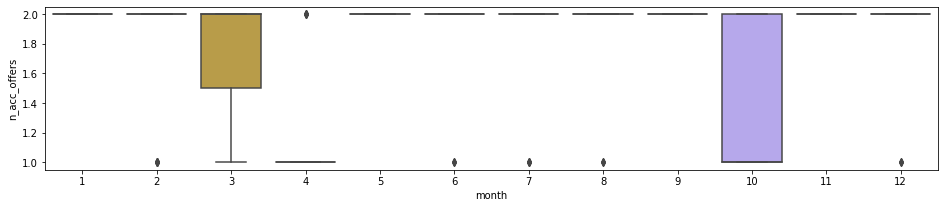

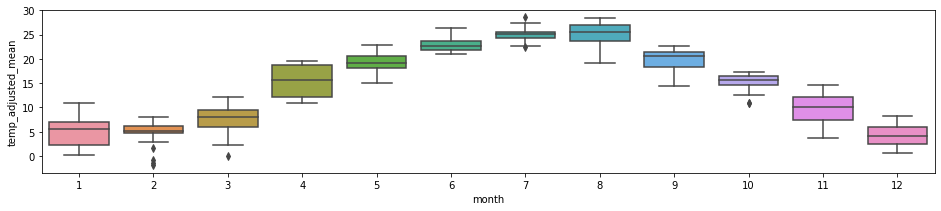

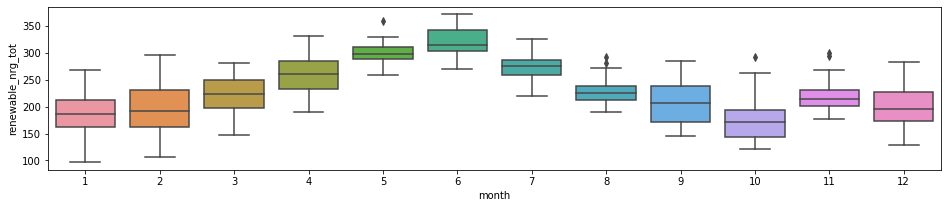

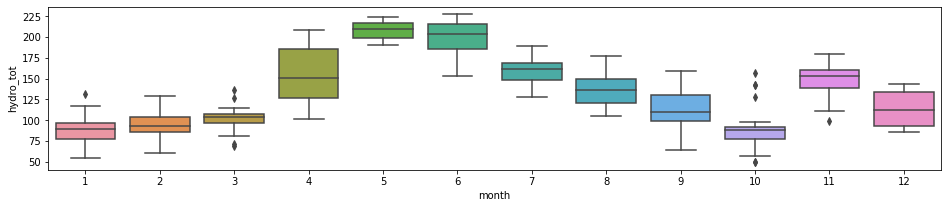

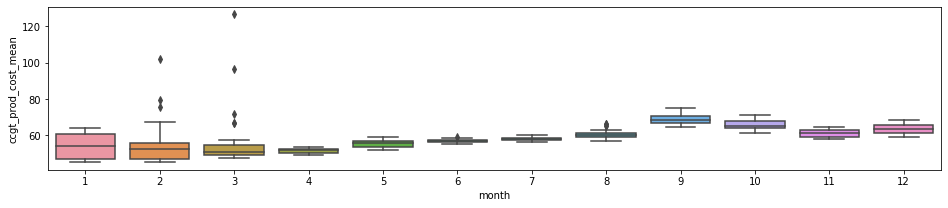

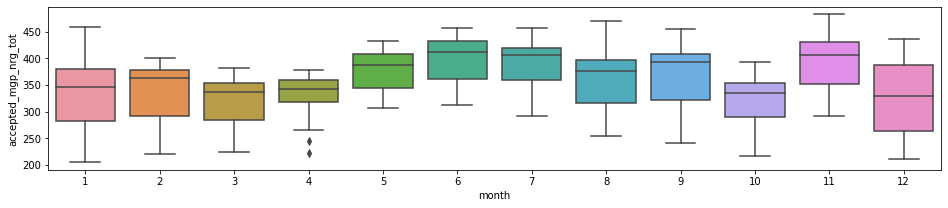

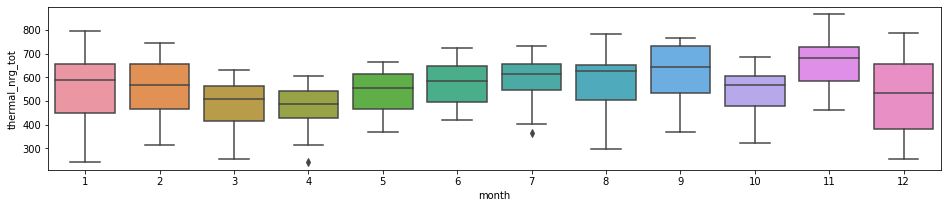

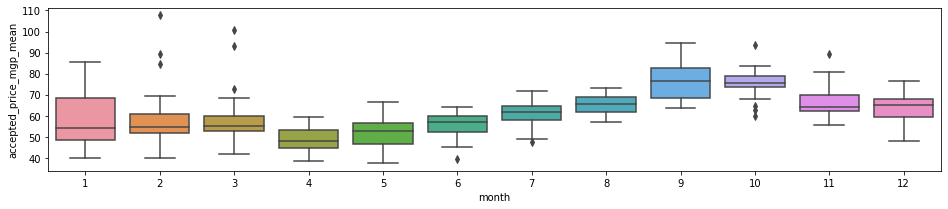

In [41]:
import seaborn as sns
    
for i, col in enumerate(ts.columns[3:-2]):
    # Draw box plot
    plt.figure(i, figsize=(16,3))
    sns.boxplot(x='month', y=col, data=ts)

### Naive time-series decomposition

Time-series have two main decompositions:
- Additive decomposition: $TS = Trend + Seasonality + Error$
- Multiplicative decomposition: $TS = Trend * Seasonality * Error$

Multiplicative decomposition, which would determine a non-linear relationship between the above components, is not possible here because the target variable `n_acc_offers` happens to be 0 quite a lot of times.

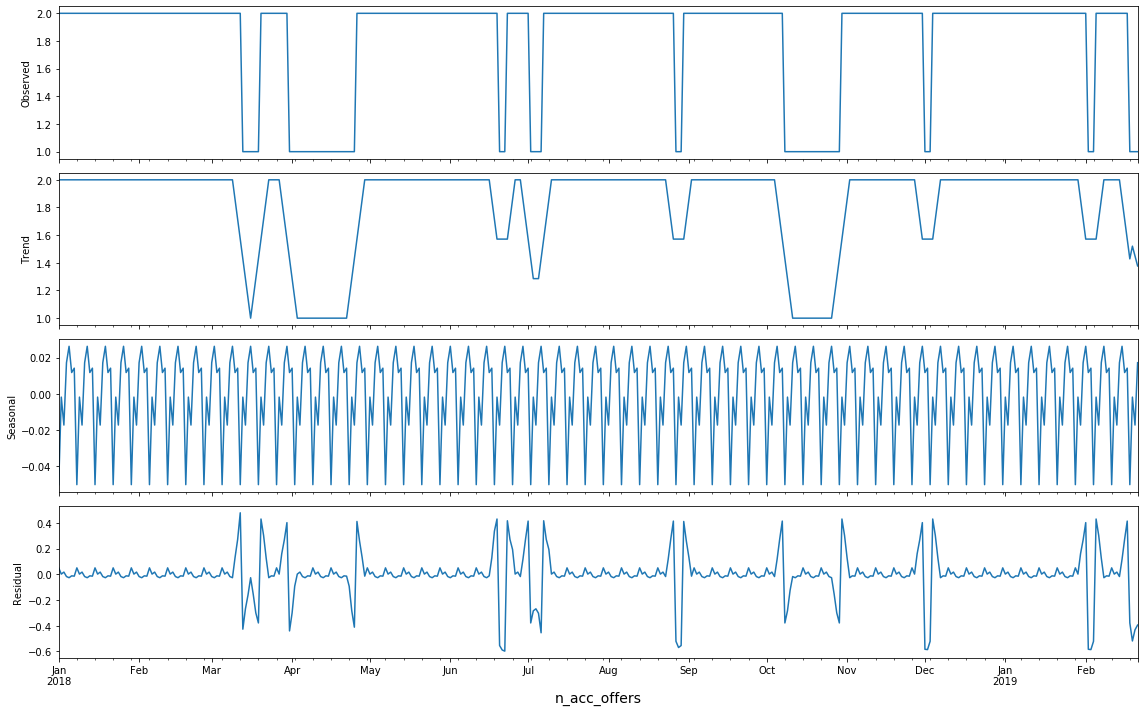

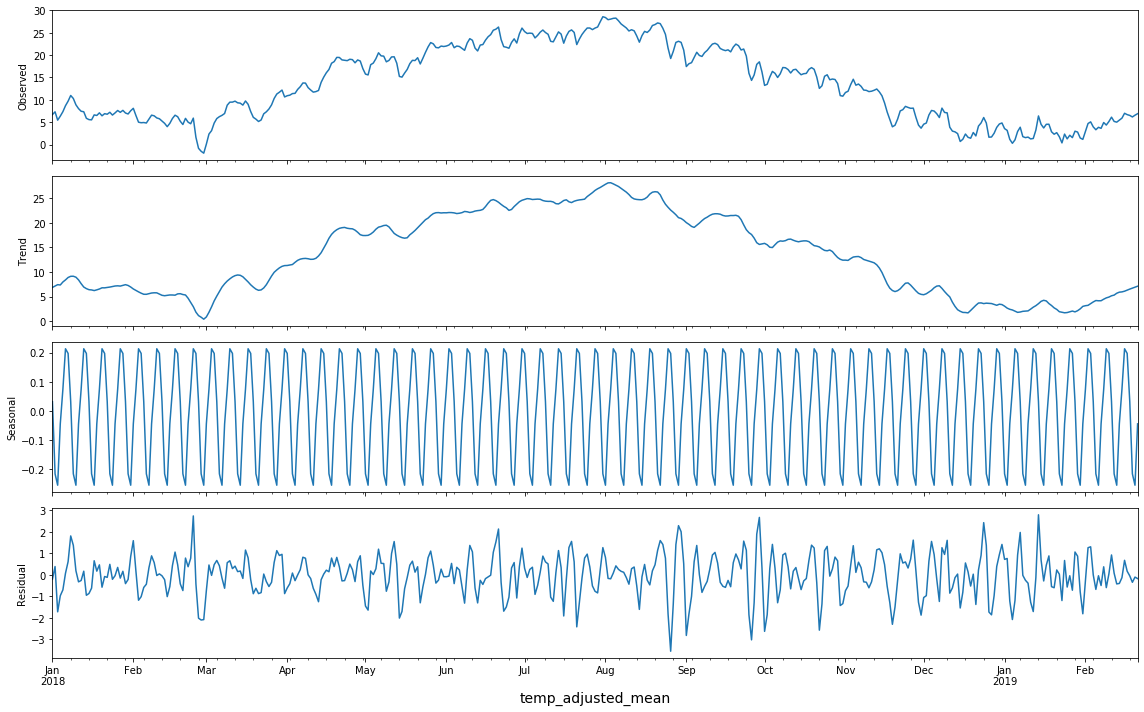

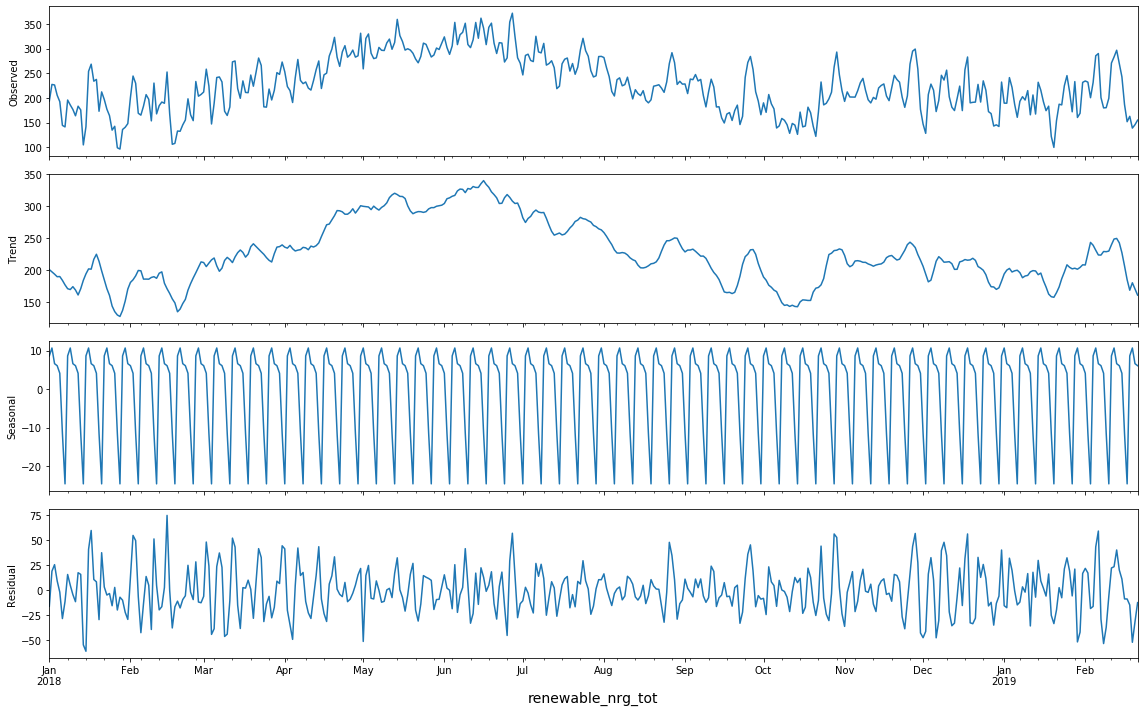

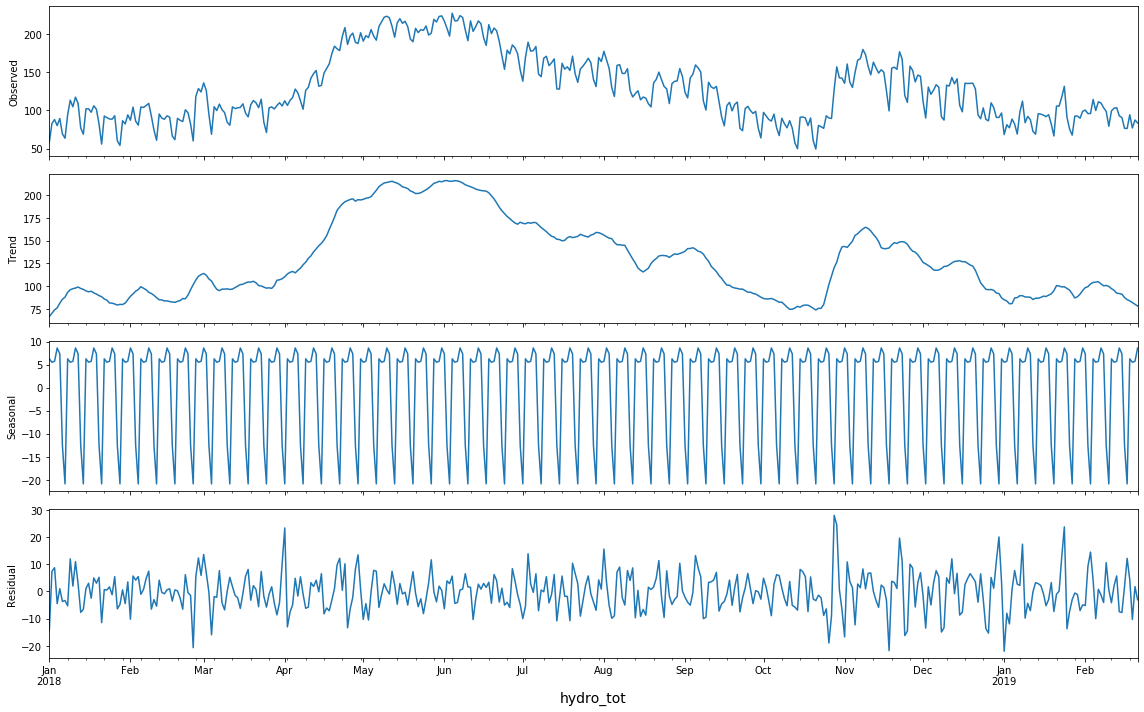

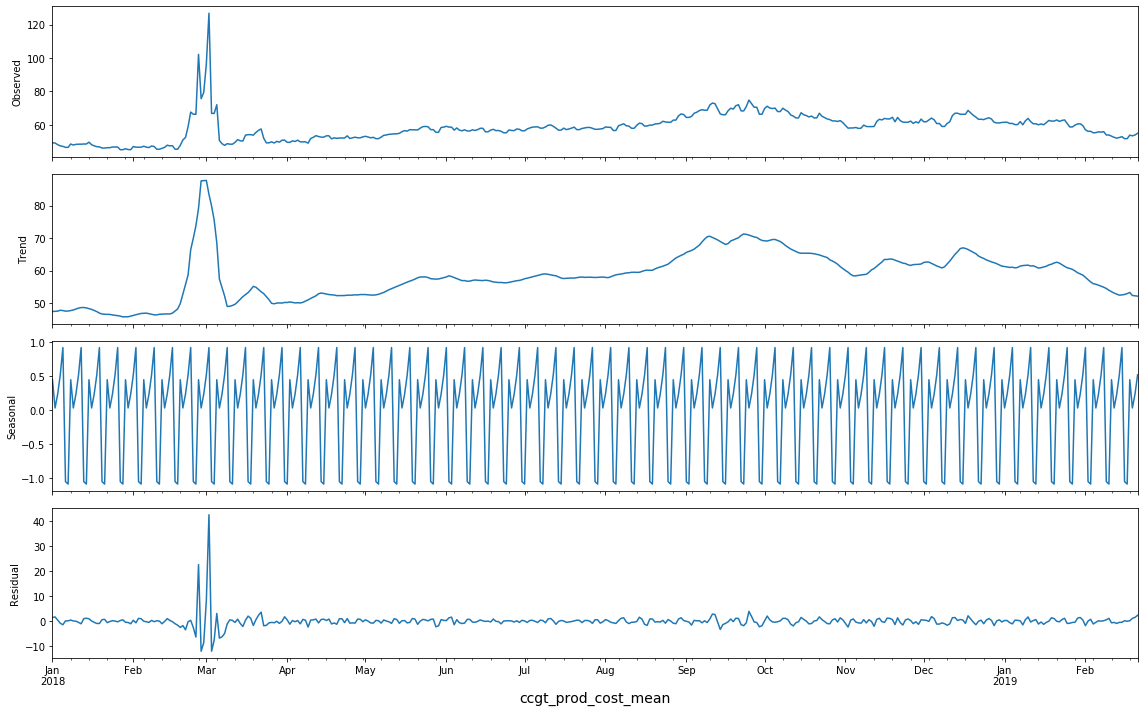

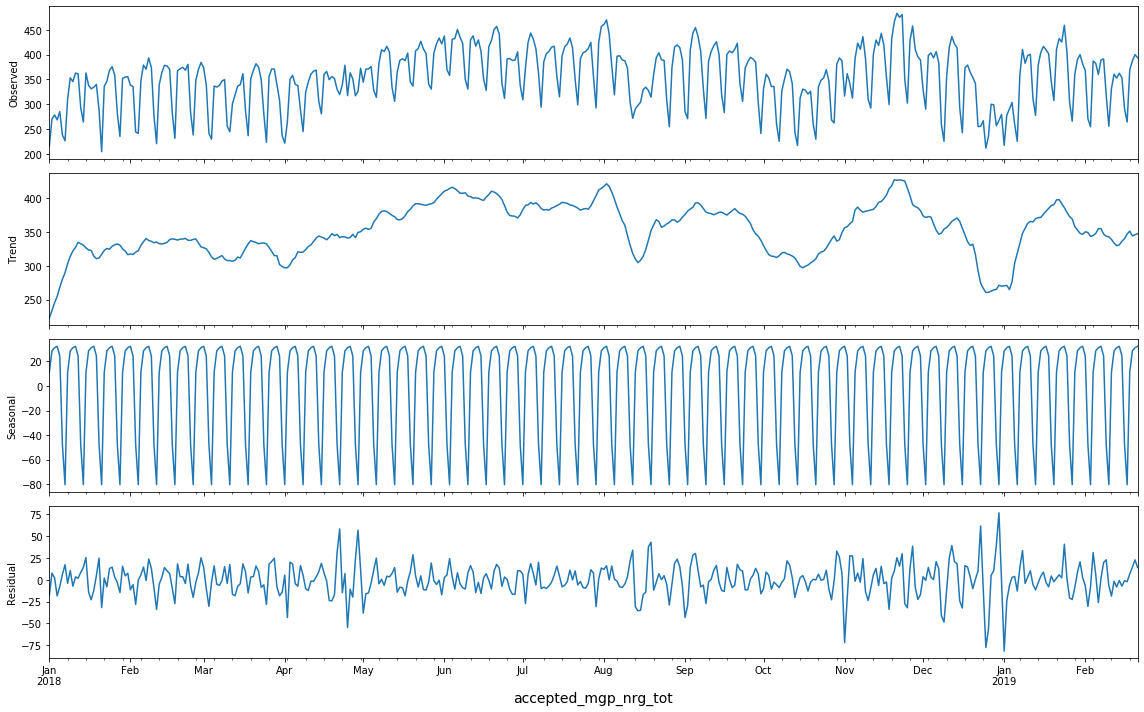

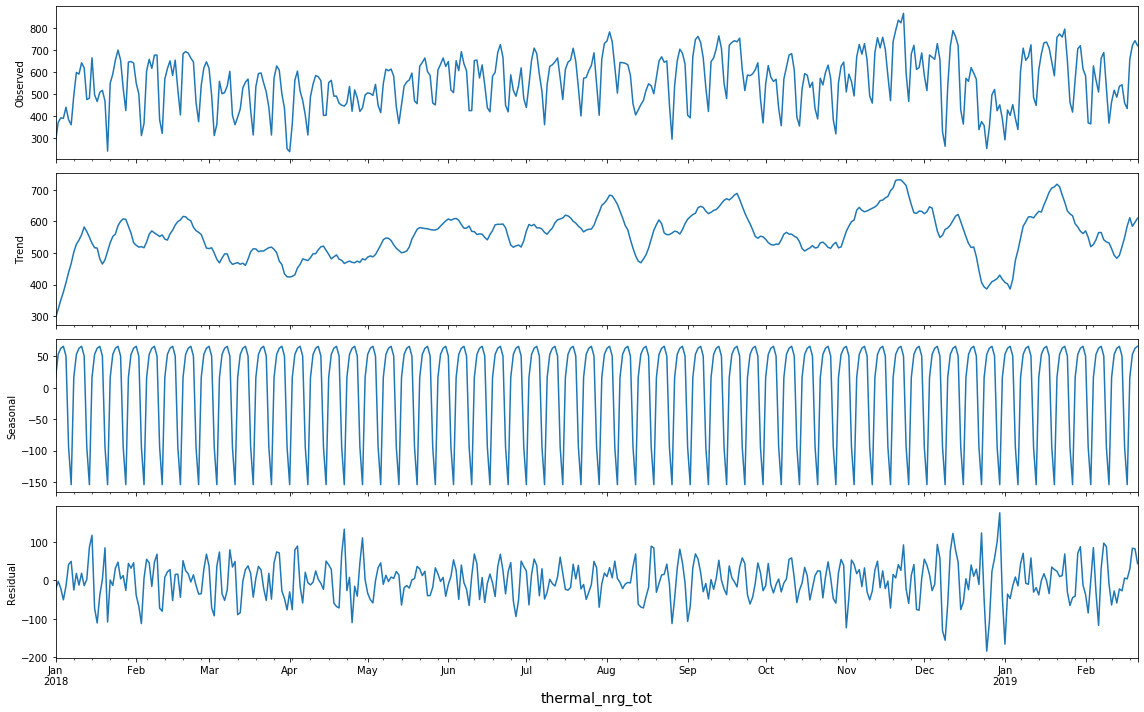

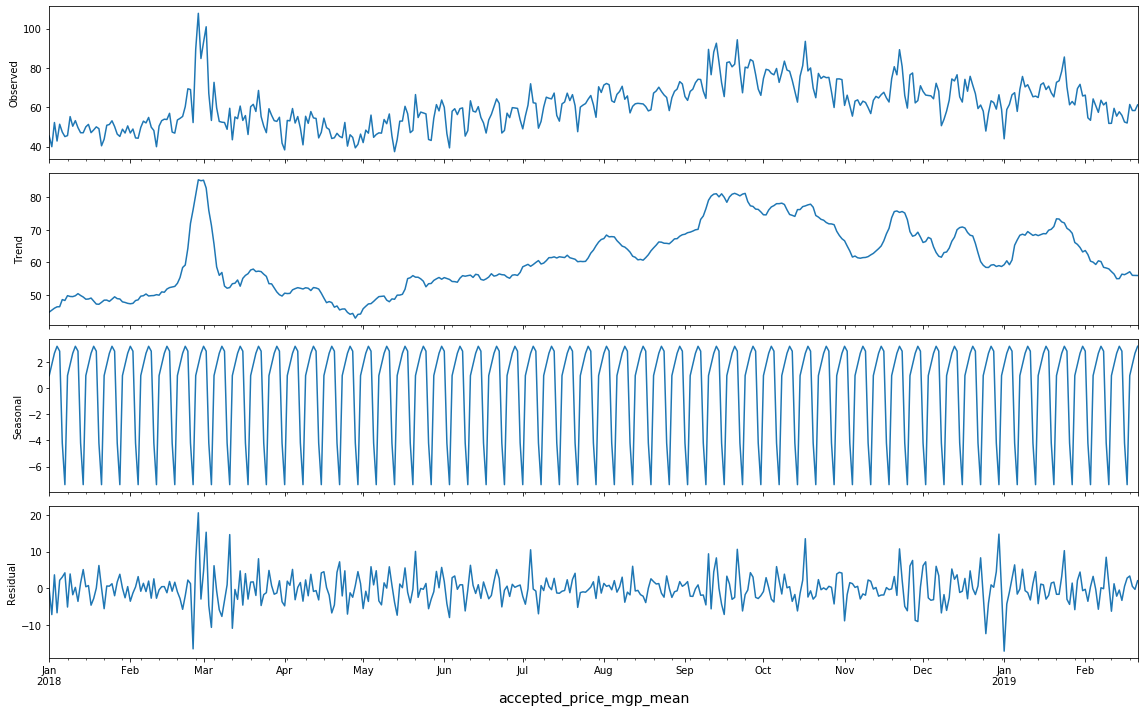

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

for col in ts.columns[3:-2]:
    # Additive decomposition
    result_add_decomp = seasonal_decompose(ts[col], model='additive',
                                extrapolate_trend='freq')
    
    if col == 'n_acc_offers':
        # Deseasonalize series
        ts_deseas = ts.n_acc_offers - result_add_decomp.seasonal

    # Plot the decomposed signal
    plt.rcParams.update({'figure.figsize': (16,10)})
    result_add_decomp.plot()
    
    plt.xlabel('%s' % col,fontsize=14)
    plt.tight_layout()
    
    plt.show()

The trend component is mostly random, with non-predictable patterns over the different time-series. It is also the one which carries the most information, since it follows the time-series better than any other. Hence, detrending may not be needed in this case study. On the other hand, though, they all seem to present the same seasonal component. Consequently, time stationarity is not likely and thus the time-series may need stationarizing.

### Time stationarity

We apply ADF and KPSS tests ***just*** to the target variable. The ADF test is typically used, where a null hypothesis on the time series possessing a unit root and being non-stationary is taken. If the P-value from the ADF test is less than the significance level (0.05), the above hypothesis is rejected.

In [43]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
result_ADF = adfuller(ts.n_acc_offers.values, autolag='AIC')
print(f'ADF statistic: {result_ADF[0]}')
print(f'P-value: {result_ADF[1]}')

for k, val in result_ADF[4].items():
    print('Critial values:')
    print(f'    {k}, {val}')
    
# KPSS test
result_KPSS = kpss(ts.n_acc_offers.values, regression='c', lags='auto')
print('\nKPSS statistic: %f' % result_KPSS[0])
print('P-value: %f' % result_KPSS[1])

for k, val in result_KPSS[3].items():
    print('Critial values:')
    print(f'    {k}, {val}')

ADF statistic: -4.568720692302747
P-value: 0.00014744763270957718
Critial values:
    1%, -3.4462831955497135
Critial values:
    5%, -2.8685636962704395
Critial values:
    10%, -2.5705114078759914

KPSS statistic: 0.084643
P-value: 0.100000
Critial values:
    10%, 0.347
Critial values:
    5%, 0.463
Critial values:
    2.5%, 0.574
Critial values:
    1%, 0.739


C:\Users\gvlos\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Both tests are passed by the time series (P-value < 0.05 for ADF, and P-value > 0.05 for KPSS). Hence, it is *stationary*.

### Autocorrelation plots

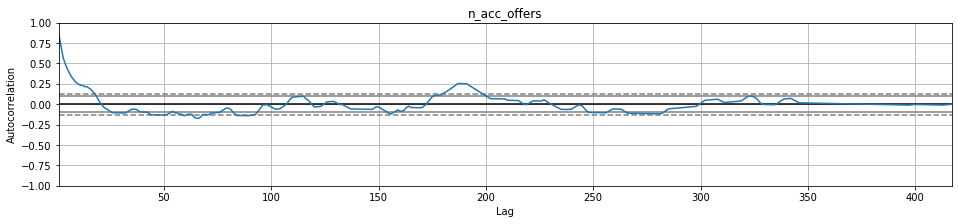

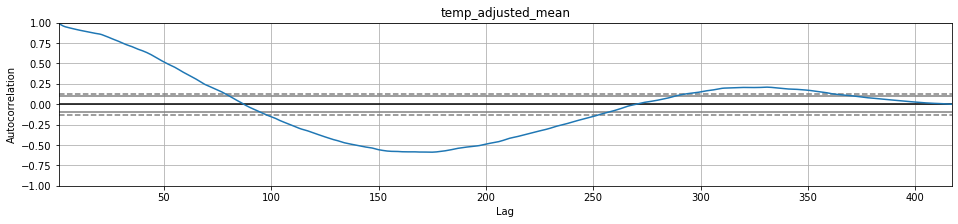

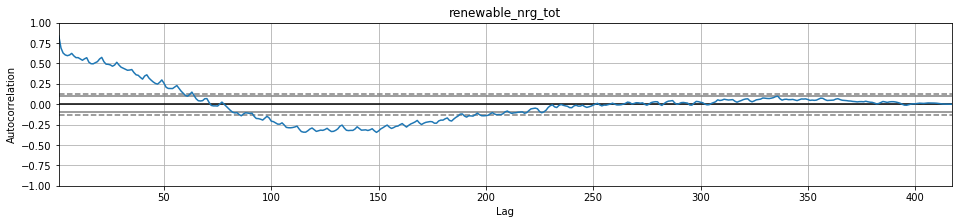

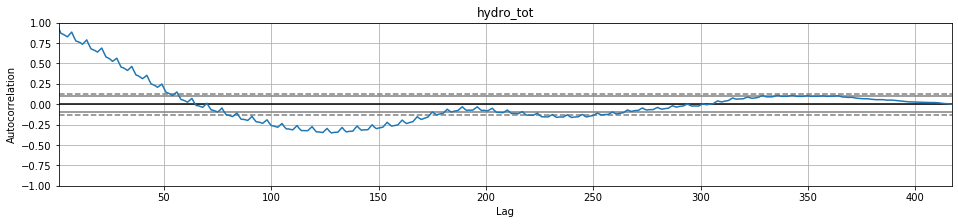

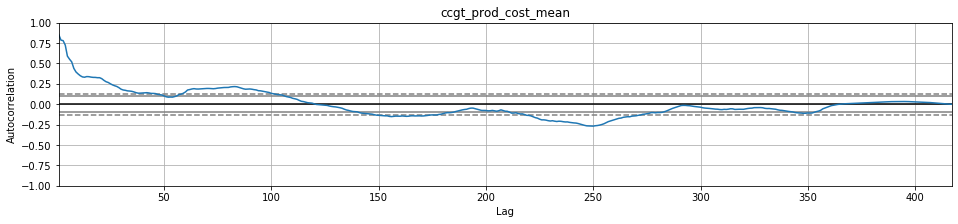

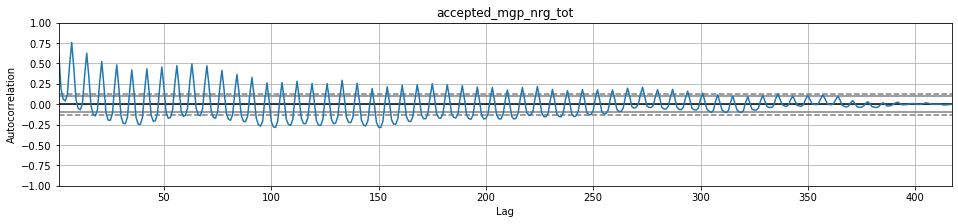

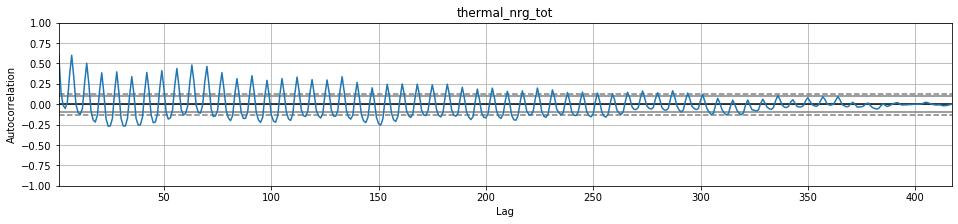

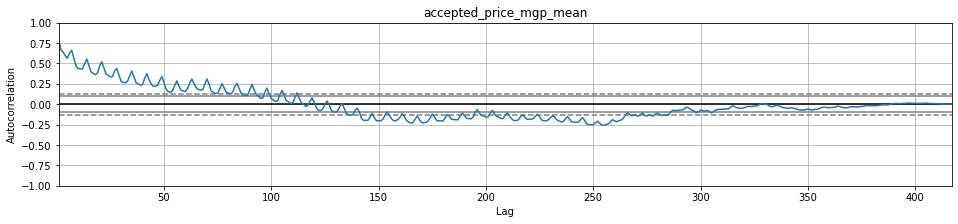

In [44]:
from pandas.plotting import autocorrelation_plot

for i, col in enumerate(ts.columns[3:-2]):
    plt.figure(i, figsize=(16,3))
    plt.tight_layout()
    
    # Draw ACF plot
    autocorrelation_plot(ts[col].tolist())
    
    plt.title('%s' % col)

Aside from temp_adjusted_mean's plot, all the time series present spikes in the ACF (*Autocorrelation function*) plot over a *7-day* span. It may be a strong indicator of a weekly seasonality, even though it gets smoother and smoother as the lag progresses to 423.

### Lag plots

A lag plot is a scatter plot of a time series against a lag of itself. It is normally used to infer on the ACF. The series is said autocorrelated, if there is any noticeable pattern in the series like the ones you see below (Lef-to-right diagonal). If there is no such pattern, the series is likely to be random white noise.

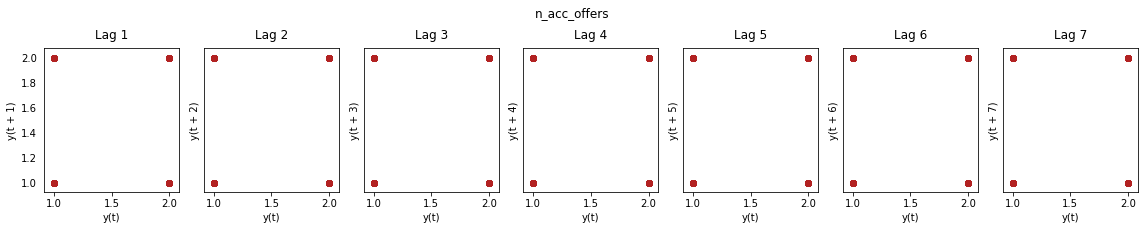

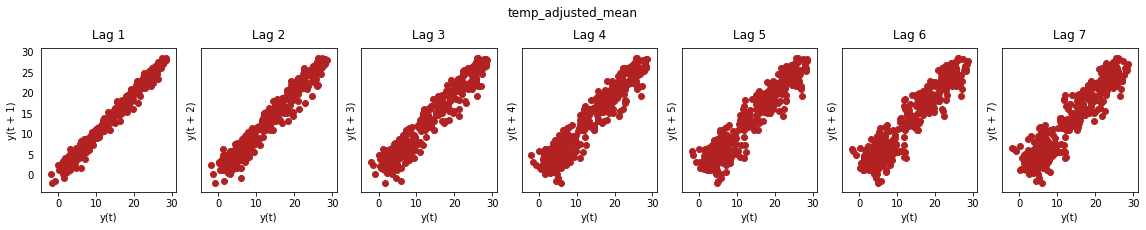

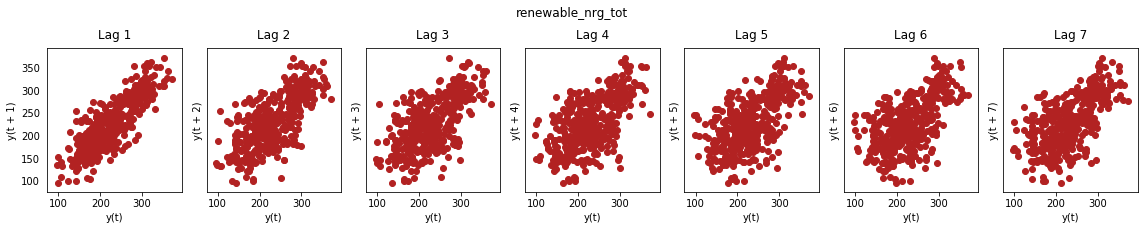

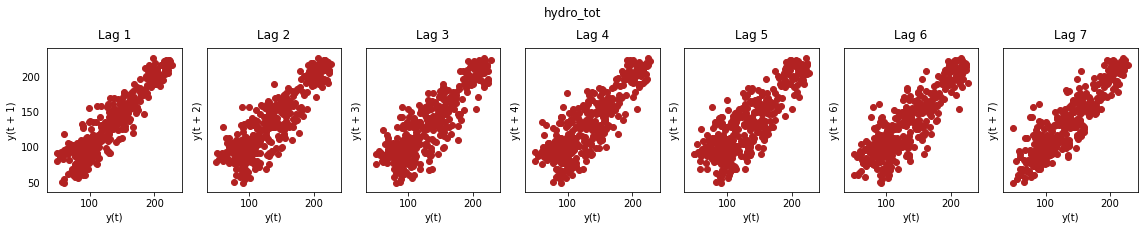

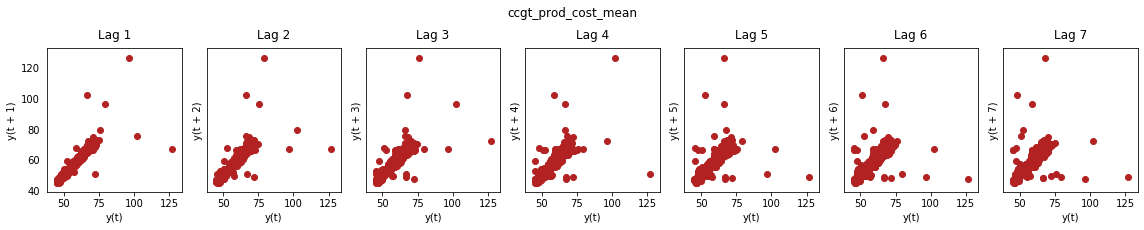

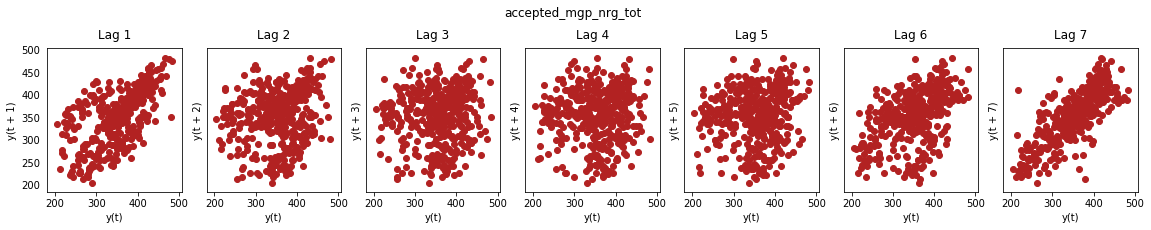

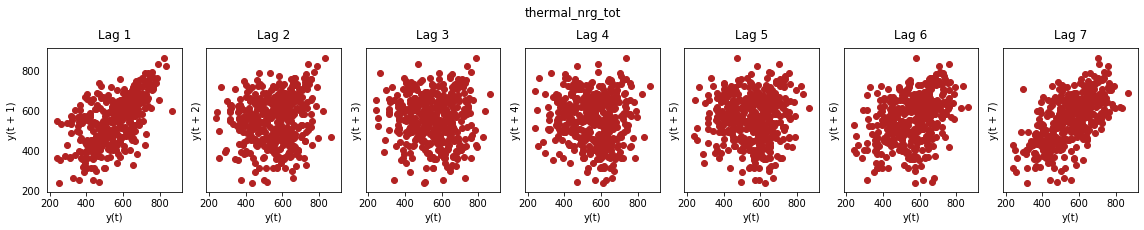

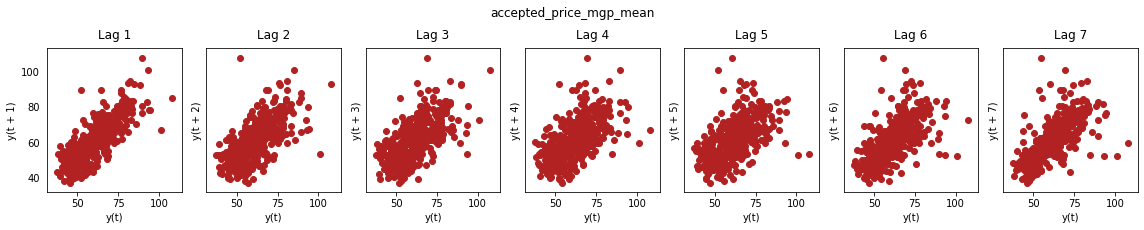

In [45]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

for col in ts.columns[3:-2]:
    # Lag plots over one week
    fig, axes = plt.subplots(1, 7, figsize=(16,3),
                    sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()[:7]):
        lag_plot(ts[col], lag=i + 1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i + 1))

    fig.suptitle('%s' % col, y=1.05)    
    fig.tight_layout()
    
    plt.show()

Many of the lag plots still present a clear diagonal pattern even with a lag of 7. This confirms the intuition of a *7-day* span seasonality across the time series that we had after looking at the spikes in the ACF plots.






### Lag features

Moving average is nothing but the average of a rolling window of defined width. But the window-width must be chosen wisely, because, a large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (i.e., 7 for a daily-wise series), will effectively nullify the seasonal component across the time series.

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. The Python implementation in the statsmodels package lets you control the degree of smoothing via the `frac` argument, which specifies the percentage of data points nearby that should be considered to fit a regression model.

#### Rolling window: 7

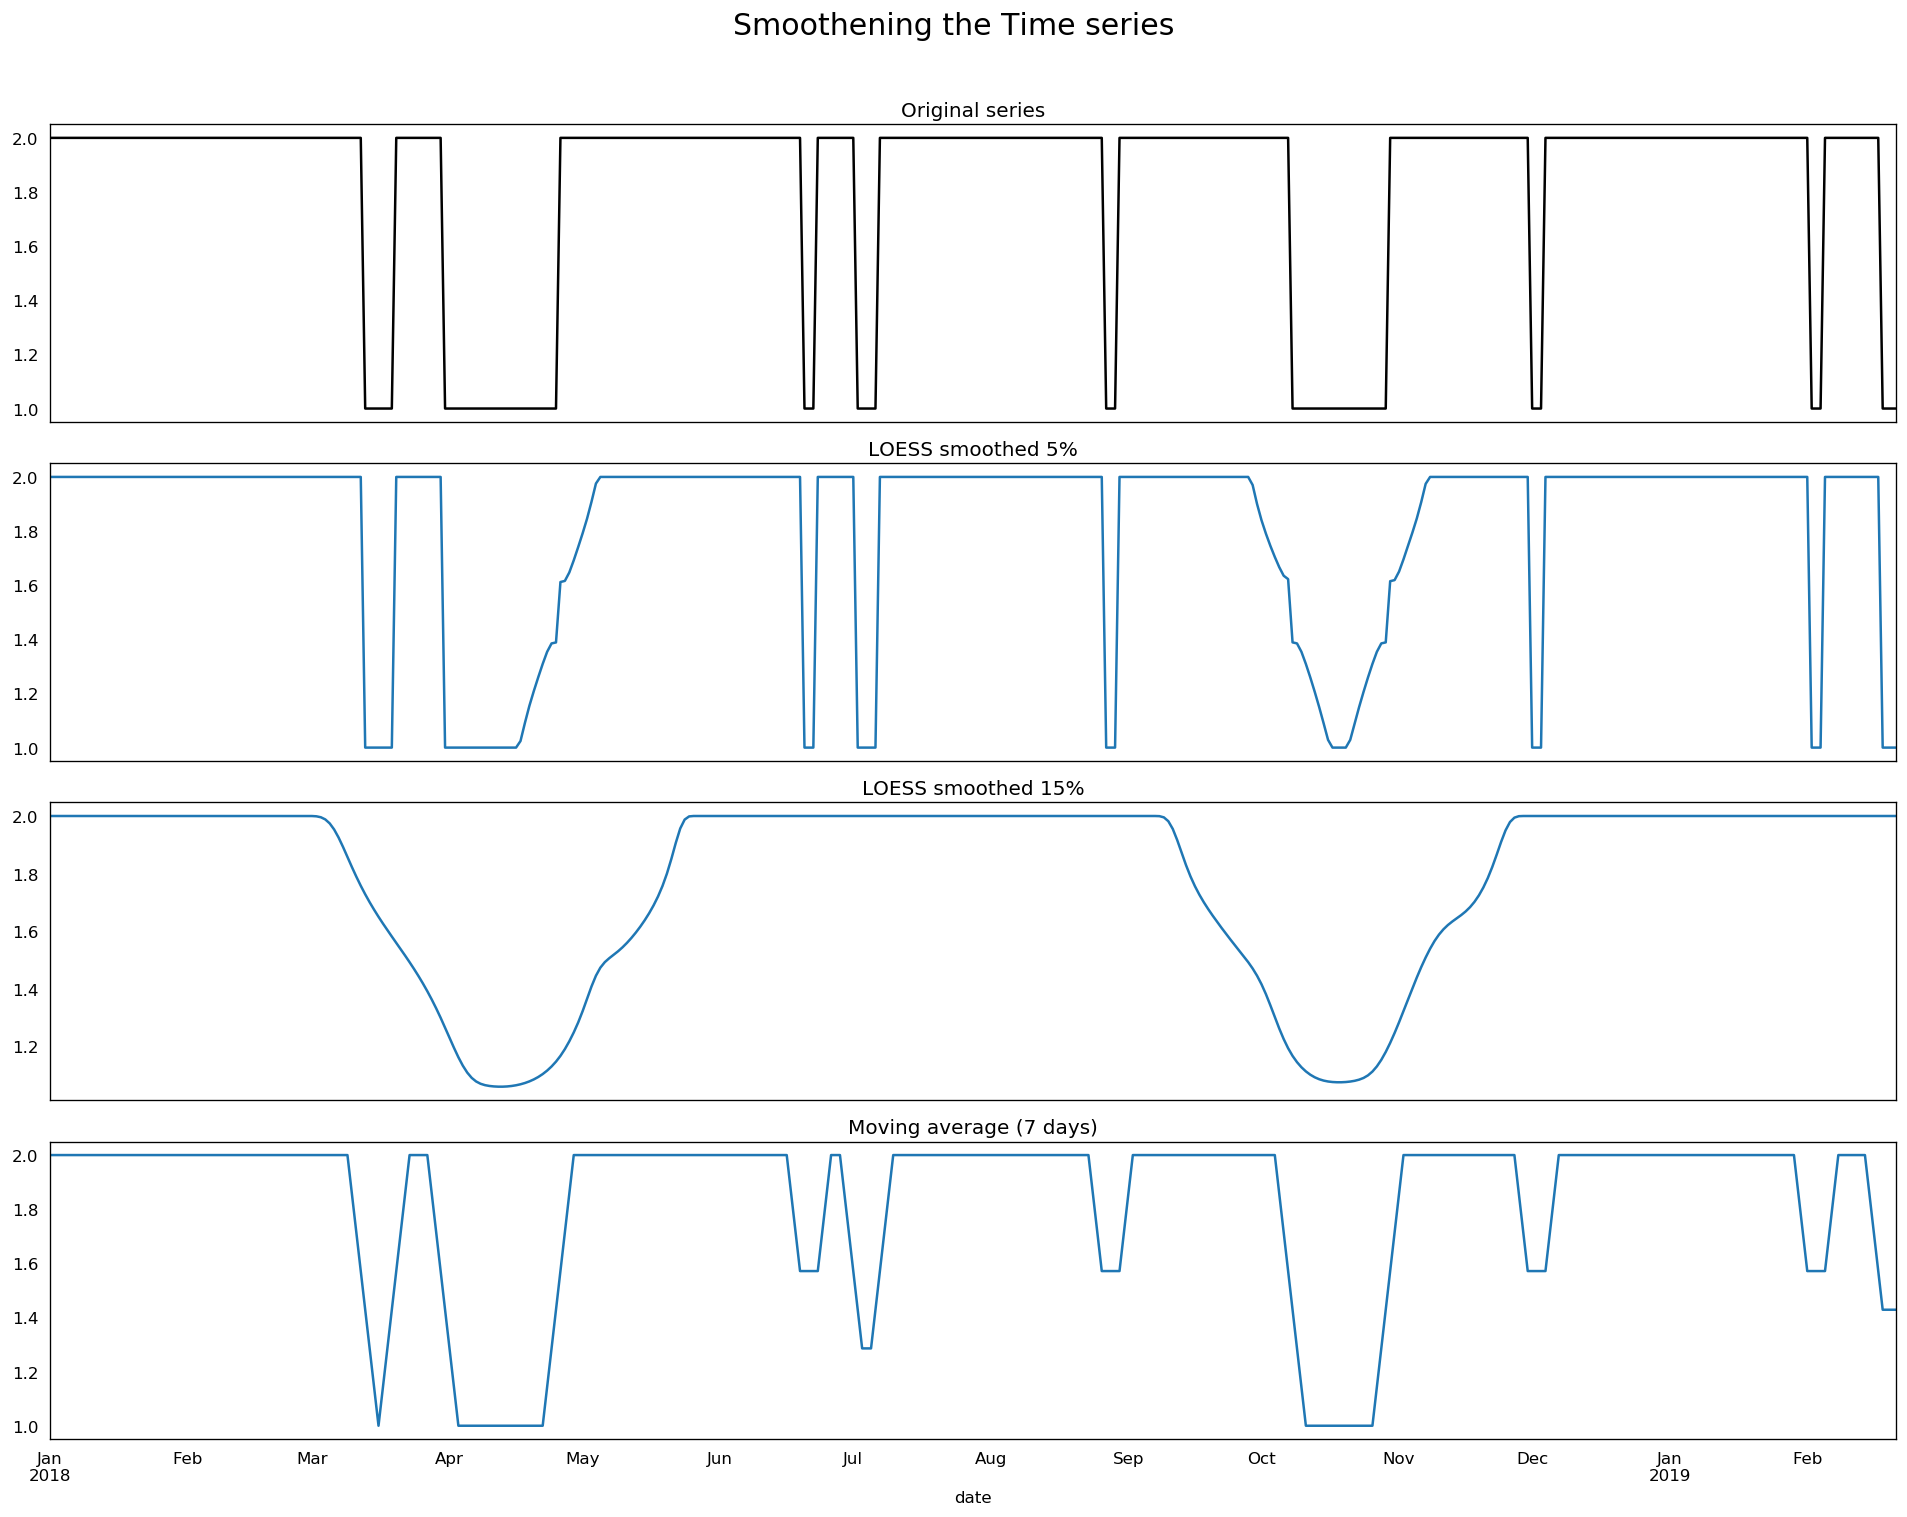

In [47]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving average
ts_ma = ts.n_acc_offers.rolling(7, center=True, closed='both').mean()

# Fill NaN values with backward fill and forward fill
ts_ma = ts_ma.bfill().ffill()

# 2. Loess smoothing (5% and 15%)
ts_loess_5  = pd.DataFrame(lowess(ts.n_acc_offers,
                    np.arange(len(ts.n_acc_offers)), frac=0.05)[:, 1],
                    index=ts.index, columns=['n_acc_offers'])

ts_loess_15 = pd.DataFrame(lowess(ts.n_acc_offers,
                    np.arange(len(ts.n_acc_offers)), frac=0.15)[:, 1],
                    index=ts.index, columns=['n_acc_offers'])

# Draw smoothed plots
fig, axes = plt.subplots(4,1, figsize=(16, 12), sharex=True, dpi=120)

ts.n_acc_offers.plot(ax=axes[0], color='k', title='Original series')

ts_loess_5.n_acc_offers.plot(ax=axes[1], title='LOESS smoothed 5%')
ts_loess_15.n_acc_offers.plot(ax=axes[2], title='LOESS smoothed 15%')

ts_ma.plot(ax=axes[3], title='Moving average (7 days)')

fig.tight_layout()
fig.suptitle('Smoothening the Time series', y=1.05, fontsize=18)

plt.show()

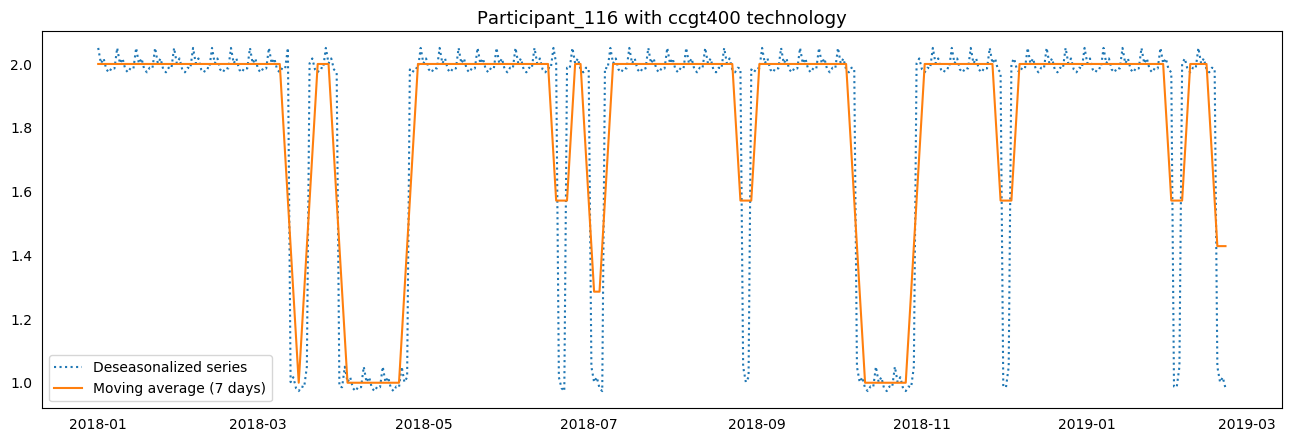

In [48]:
# Comparison plot
plt.figure(figsize=(16,5), dpi=100)

plt.title('%s with %s technology' % (unique_pairs[ts_id][0].capitalize(),
                        unique_pairs[ts_id][1]), fontsize=13)

plt.plot(ts_deseas, label="Deseasonalized series", ls=':')
plt.plot(ts_ma, label='Moving average (7 days)')

plt.legend()

#### Rolling window: 3

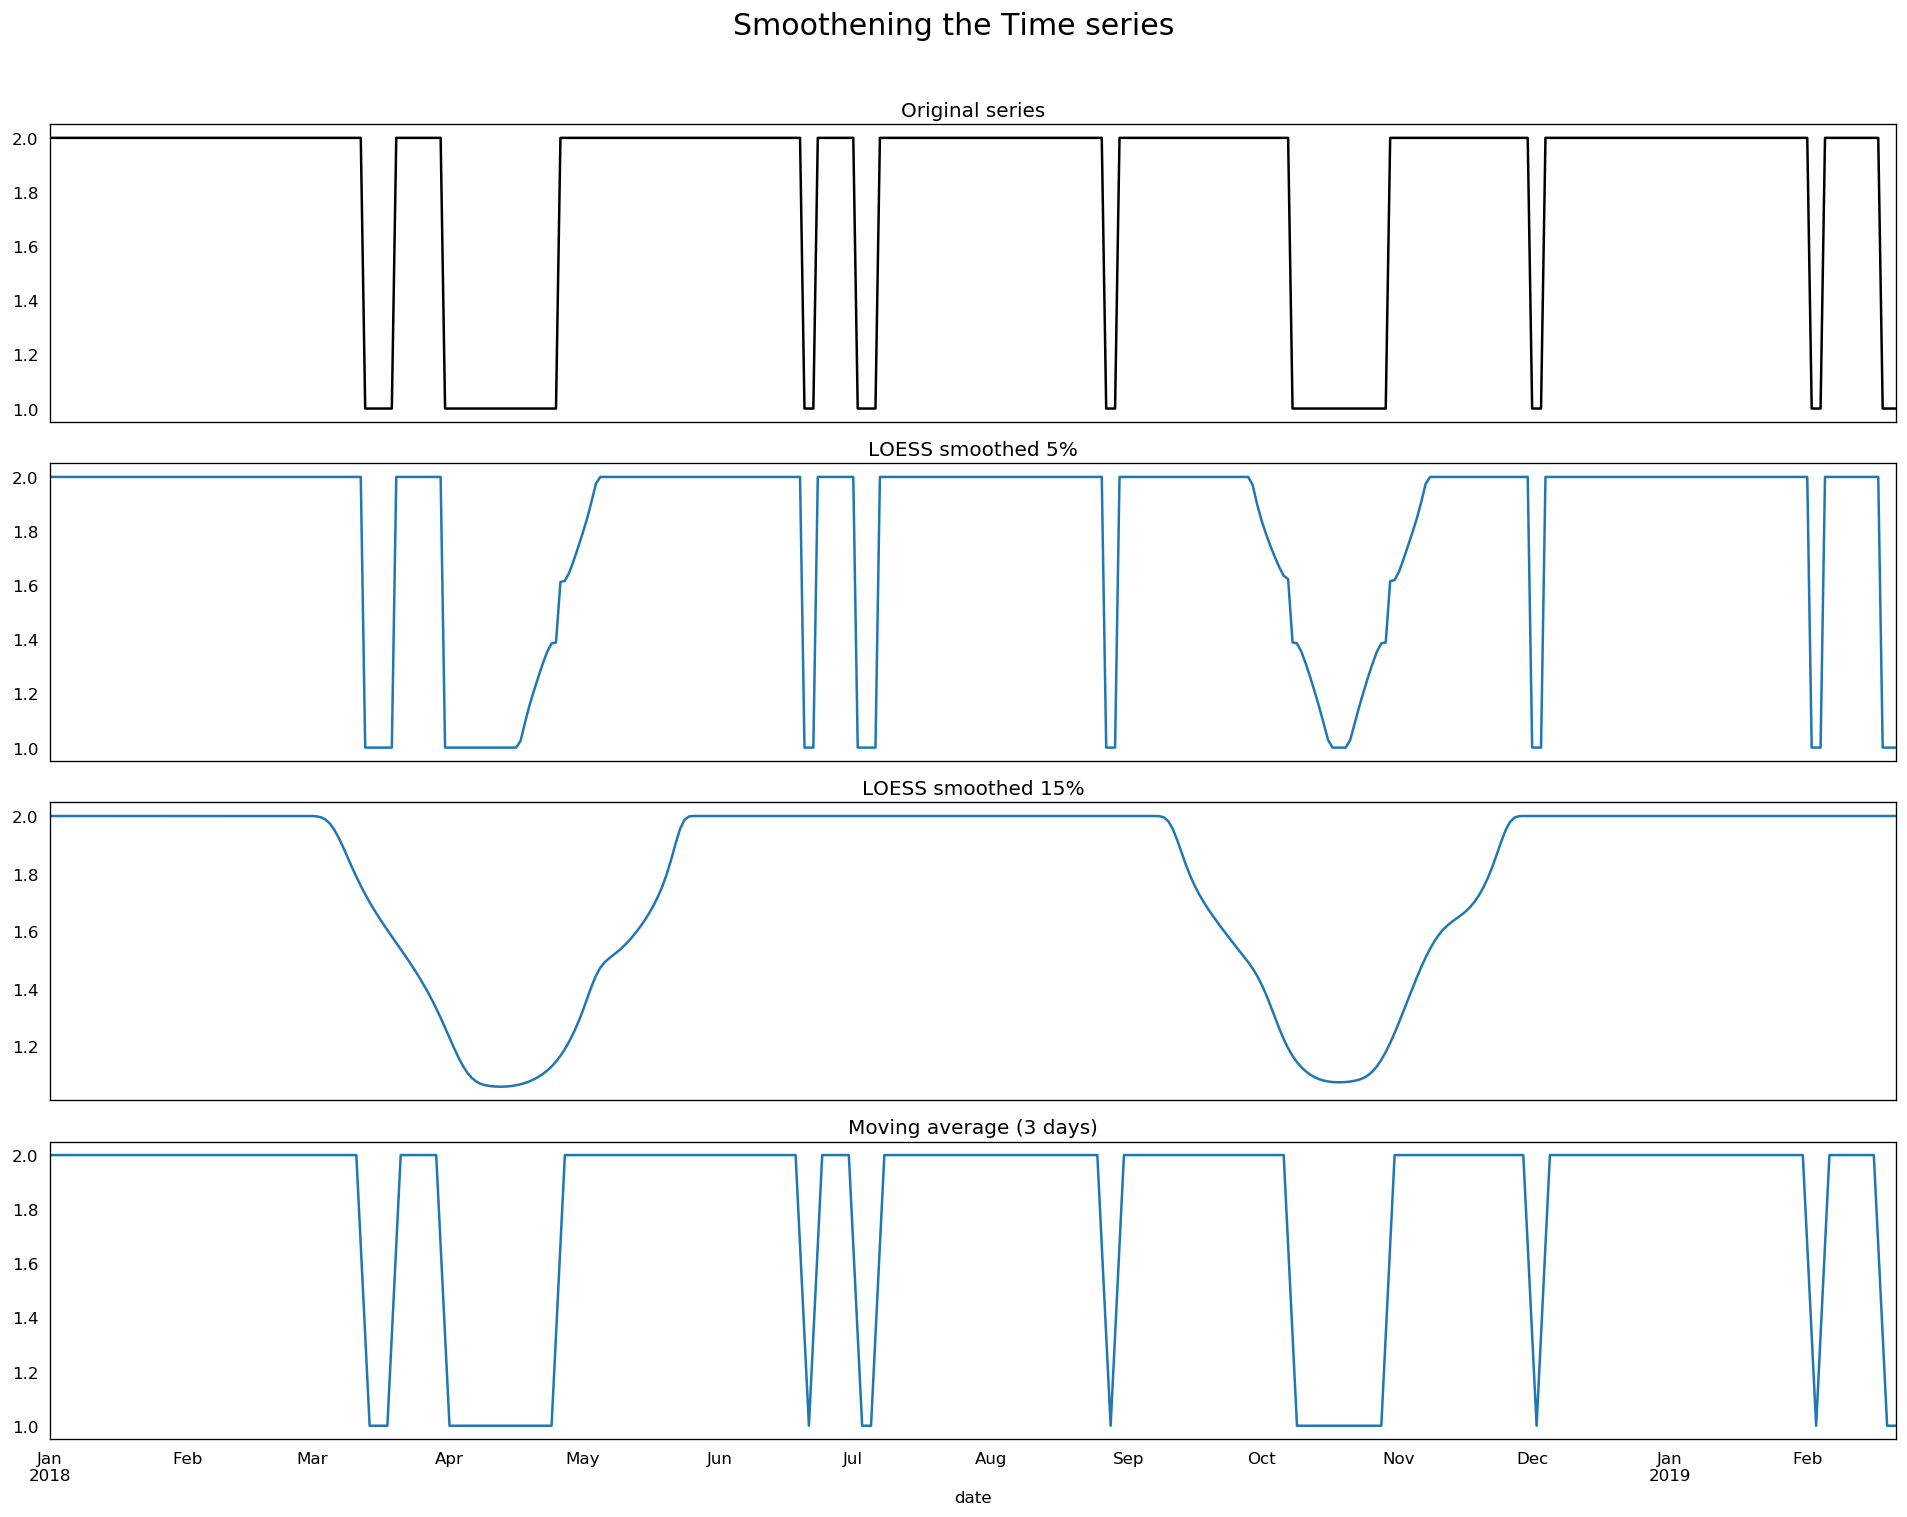

In [49]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving average
ts_ma_3 = ts.n_acc_offers.rolling(3, center=True, closed='both').mean()

# Fill NaN values with backward fill and forward fill
ts_ma_3 = ts_ma_3.bfill().ffill()

# 2. Loess smoothing (5% and 15%)
ts_loess_5  = pd.DataFrame(lowess(ts.n_acc_offers,
                    np.arange(len(ts.n_acc_offers)), frac=0.05)[:, 1],
                    index=ts.index, columns=['n_acc_offers'])

ts_loess_15 = pd.DataFrame(lowess(ts.n_acc_offers,
                    np.arange(len(ts.n_acc_offers)), frac=0.15)[:, 1],
                    index=ts.index, columns=['n_acc_offers'])

# Draw smoothed plots
fig, axes = plt.subplots(4,1, figsize=(16, 12), sharex=True, dpi=120)

ts.n_acc_offers.plot(ax=axes[0], color='k', title='Original series')

ts_loess_5.n_acc_offers.plot(ax=axes[1], title='LOESS smoothed 5%')
ts_loess_15.n_acc_offers.plot(ax=axes[2], title='LOESS smoothed 15%')

ts_ma_3.plot(ax=axes[3], title='Moving average (3 days)')

fig.tight_layout()
fig.suptitle('Smoothening the Time series', y=1.05, fontsize=18)

plt.show()

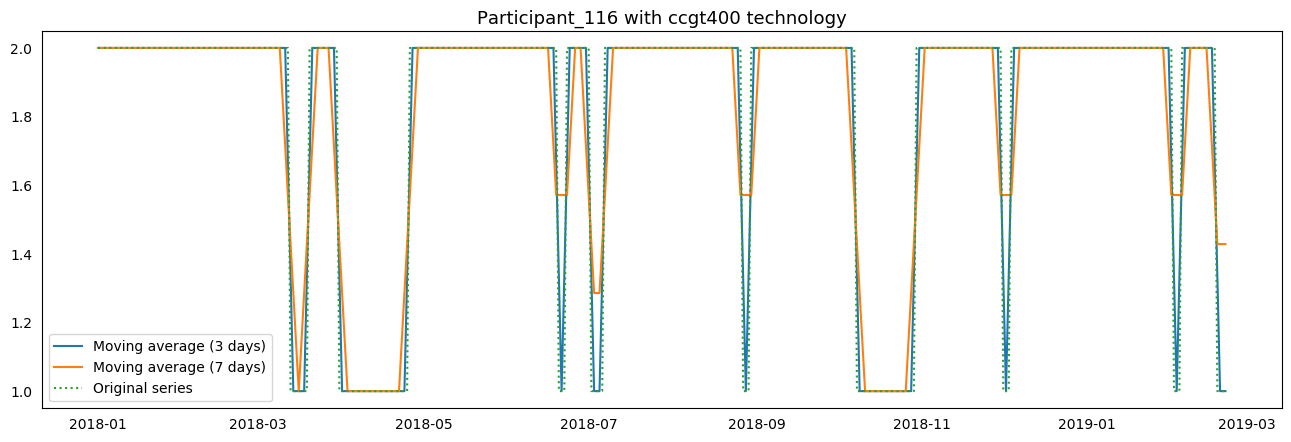

In [50]:
# Comparison plot
plt.figure(figsize=(16,5), dpi=100)

plt.title('%s with %s technology' % (unique_pairs[ts_id][0].capitalize(),
                        unique_pairs[ts_id][1]), fontsize=13)

plt.plot(ts_ma_3, label="Moving average (3 days)")
plt.plot(ts_ma, label='Moving average (7 days)')
plt.plot(ts.n_acc_offers, label='Original series', ls = ':')

plt.legend()

## Conclusion

Moving averages of 3-7 days seem enough as lag features.

### Construct time series Train & Test

In [51]:
time_series_train = []
time_series_test_target = []

In [52]:
unique_pairs_train = train_df.groupby(['participant','technology']) \
    .size().reset_index().drop(columns={0}).values

for pair in unique_pairs_train:
    # Extract corrisponding time-series
    ts = train_df[np.logical_and(train_df.participant == pair[0],
                        train_df.technology == pair[1])] \
                .reset_index(drop=True)
    
    # Set the date column as a DatetimeIndex, which
    # is useful for plots and later processing.
    ts.index = pd.DatetimeIndex(data=ts.date)    
    time_series_train.append(ts)

In [54]:
from datetime import timedelta

unique_pairs_test_target = test_target_df.groupby(['participant','technology']) \
    .size().reset_index().drop(columns={0}).values

for pair in unique_pairs_test_target:
    # Extract corrisponding time-series
    ts = test_target_df[np.logical_and(test_target_df.participant == pair[0],
                        test_target_df.technology == pair[1])] \
                .reset_index(drop=True)
    
    # Normalize dates to 15-21/02/2019
    
    # Even though this time series represents
    # the offers accepted in the span 22-28/02/2019,
    # it will be predicted using the data 7-days
    # ahead in the span 15-21. Shifting the
    # date column will help with later aggregation.
    ts.date -= timedelta(days=7)

    # Set the date column as a DatetimeIndex, which
    # is useful for plots and later processing.
    ts.index = pd.DatetimeIndex(data=ts.date)
    time_series_test_target.append(ts)

### Compute 3-7 days Lag features

In [55]:
for ts in time_series_train:
    # For each feature of interest, apart
    # participant, technology and date columns.
    for col in ts.columns[3:]:
        ts[col + '_3'] = ts[col].rolling(3, center=True, closed='both').mean()
        ts[col + '_7'] = ts[col].rolling(7, center=True, closed='both').mean()
        
        # Fill NaN values with backward and forward fill methods
        ts[col + '_3'] = ts[col + '_3'].bfill().ffill()
        ts[col + '_7'] = ts[col + '_7'].bfill().ffill()

### Shifting n_acc_offers 7-days ahead


In [56]:
for ts in time_series_train:
    a = ts.loc[:, 'n_acc_offers']
    b = a.values

    for i in range(len(b) - 7):
        b[i] = b[i + 7]

    a = b

### Extract 7-days input test

In [57]:
time_series_test_input = []

for ts in time_series_train:
    ts_test_input = ts.tail(7).drop(columns='n_acc_offers')
    ts.drop(ts_test_input.index, inplace=True) 
    
    # Test phase instances
    time_series_test_input.append(ts_test_input)

### Concat into Pandas DFs

In [58]:
time_series_test_input[5].tail()

,participant,technology,date,temp_adjusted_mean,renewable_nrg_tot,hydro_tot,ccgt_prod_cost_mean,accepted_mgp_nrg_tot,thermal_nrg_tot,accepted_price_mgp_mean,n_acc_offers_3,n_acc_offers_7,temp_adjusted_mean_3,temp_adjusted_mean_7,renewable_nrg_tot_3,renewable_nrg_tot_7,hydro_tot_3,hydro_tot_7,ccgt_prod_cost_mean_3,ccgt_prod_cost_mean_7,accepted_mgp_nrg_tot_3,accepted_mgp_nrg_tot_7,thermal_nrg_tot_3,thermal_nrg_tot_7,accepted_price_mgp_mean_3,accepted_price_mgp_mean_7
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-17,participant_120,ccgt800,2019-02-17,6.693423,151.887224,76.272202,51.8,264.278831,435.399067,52.002549,1.0,1.0,6.733876,6.329436,167.122883,185.462544,82.365806,85.000433,52.500000,52.928571,308.273552,346.879991,517.929454,585.381880,55.314631,56.607195
2019-02-18,participant_120,ccgt800,2019-02-18,6.514475,162.806653,94.277680,53.9,369.210914,657.662044,61.422917,1.0,1.0,6.459876,6.534388,151.213344,169.131505,82.527993,83.670588,53.066667,53.285714,340.246075,351.349348,604.889044,611.644823,57.260919,57.105499
2019-02-19,participant_120,ccgt800,2019-02-19,6.171729,138.946156,77.034097,53.5,387.248480,721.606022,58.357293,1.0,1.0,6.416871,6.534388,149.178952,169.131505,86.234870,83.670588,53.800000,53.285714,385.453160,351.349348,707.383626,611.644823,59.372366,57.105499
2019-02-20,participant_120,ccgt800,2019-02-20,6.564410,145.784046,87.392832,54.0,399.900086,742.882811,58.336888,1.0,1.0,6.544455,6.534388,146.570028,169.131505,82.665766,83.670588,54.166667,53.285714,393.645168,351.349348,728.197013,611.644823,59.300560,57.105499
2019-02-21,participant_120,ccgt800,2019-02-21,6.897225,154.979882,83.570368,55.0,393.786939,720.102204,61.207500,1.0,1.0,6.544455,6.534388,146.570028,169.131505,82.665766,83.670588,54.166667,53.285714,393.645168,351.349348,728.197013,611.644823,59.300560,57.105499


In [59]:
time_series_train_df = pd.concat([ts for ts in time_series_train])

In [60]:
time_series_test_target_df  = pd.concat([ts for ts in time_series_test_target])
time_series_test_input_df  = pd.concat([ts for ts in time_series_test_input])

In [61]:
time_series_test_target_df.tail()

,participant,technology,date,n_acc_offers
date,,,,
2019-02-17,participant_96,reservoir,2019-02-17,1
2019-02-18,participant_96,reservoir,2019-02-18,2
2019-02-19,participant_96,reservoir,2019-02-19,2
2019-02-20,participant_96,reservoir,2019-02-20,3
2019-02-21,participant_96,reservoir,2019-02-21,3


In [63]:
time_series_train_df.to_csv('./generated_csv/IREN_train.csv', sep=';', index=False)

In [64]:
time_series_test_input_df.to_csv('./generated_csv/IREN_test_X.csv', sep=';', index=False)
time_series_test_target_df.to_csv('./generated_csv/IREN_test_Y.csv', sep=';', index=False)